In [1]:
# All imports should be in first cell
import cartopy
import GMesh
import importlib
import netCDF4
import numpy as np
import matplotlib.pyplot as plt

# Create a target grid

This creates a regular spherical (geographic) grid covering Strait of Dover 1$^\circ$E--2$^\circ$E, 50.5$^\circ$N--51.5$^\circ$N.

<GMesh nj:9 ni:10 shape:(9,10)>
Target mesh longitude range: 1.0 2.0
Target mesh latitude range: 50.75 51.5


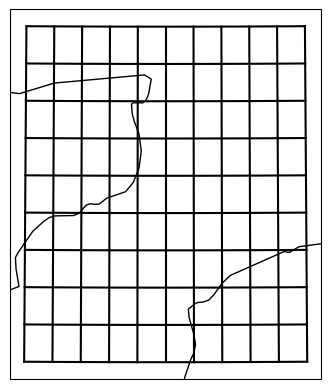

In [2]:
#Reload the GMesh tool (in case you change something in the tool and want it to take effect in this notebook)
importlib.reload(GMesh)
target_mesh = GMesh.GMesh( lon=np.linspace(1, 2, 11), lat=np.linspace(50.75, 51.5, 10) )
print( target_mesh )
ax = plt.subplot(111, projection=cartopy.crs.NearsidePerspective(central_longitude=1.5, central_latitude=51))
ax.coastlines()
target_mesh.plot(ax, transform=cartopy.crs.Geodetic())
print('Target mesh longitude range:',target_mesh.lon.min(),target_mesh.lon.max())
print('Target mesh latitude range:',target_mesh.lat.min(),target_mesh.lat.max())

# Open and read a topographic dataset

Open a topography dataset, check that the topography is on a uniform grid.

In [3]:
# URL of topographic data, names of longitude, latitude and elevation variables
url,vx,vy,ve = '/archive/gold/datasets/topography/GEBCO_08_v1.nc','longitude','latitude','depth'
# url,vx,vy,ve = '/archive/gold/datasets/topography/GEBCO_2023/GEBCO_2023.nc','lon','lat','elevation'
# url,vx,vy,ve = 'http://thredds.socib.es/thredds/dodsC/ancillary_data/bathymetry/MED_GEBCO_30sec.nc','lon','lat','elevation'
# url,vx,vy,ve = 'http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NGDC/.ETOPO1/.z_bedrock/dods','lon','lat','z_bedrock'
topo_data = netCDF4.Dataset(url)

# Read coordinates of topography
topo_lon = np.array( topo_data.variables[vx] )
topo_lat = np.array( topo_data.variables[vy] )

# Shrink topo data for purposes of vizualization/testing
subsamp = slice(None,None,5)
topo_data_z = topo_data.variables[ve][subsamp,subsamp]
topo_lon = topo_lon[subsamp]
topo_lat = topo_lat[subsamp]

print('topography grid array shapes: ',topo_lon.shape,topo_lat.shape)
print('topography longitude range:',topo_lon.min(),topo_lon.max())
print('topography latitude range:',topo_lat.min(),topo_lat.max())

print('Is mesh uniform?', GMesh.is_mesh_uniform( topo_lon, topo_lat ) )

# Indices in topographic data
tis,tjs = target_mesh.find_source_spanning_slices( topo_lon, topo_lat )
print('Slices:', tis, tjs )

# Read elevation data
topo_elv = topo_data_z[tjs,tis]
# Extract appropriate coordinates
topo_lon = topo_lon[tis]
topo_lat = topo_lat[tjs]

print('Topo shape:', topo_elv.shape)
print('topography longitude range:',topo_lon.min(),topo_lon.max())
print('topography latitude range:',topo_lat.min(),topo_lat.max())

topography grid array shapes:  (8640,) (4320,)
topography longitude range: -179.99583333333334 179.96249999999998
topography latitude range: -89.99583333333334 89.9625
Is mesh uniform? True
Slices: slice(4344, 4369, None) slice(3378, 3397, None)
Topo shape: (19, 25)
topography longitude range: 1.0041666666666629 2.004166666666663
topography latitude range: 50.75416666666666 51.50416666666666


Create a mesh for the purpose of precise plotting of topography

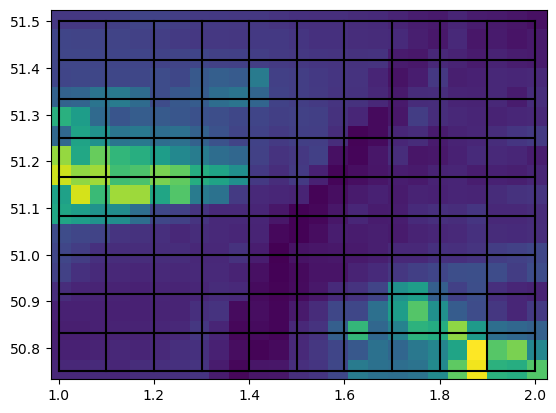

In [4]:
topo_mesh = GMesh.GMesh( lon=topo_lon, lat=topo_lat, from_cell_center=True)
ax = plt.subplot(111)#, projection=cartopy.crs.NearsidePerspective(central_longitude=1.5, central_latitude=51))
topo_mesh.pcolormesh( ax, topo_elv)#, transform=cartopy.crs.PlateCarree() )
target_mesh.plot(ax)#, transform=cartopy.crs.PlateCarree())

Flag topography cells that are sampled by mesh nodes

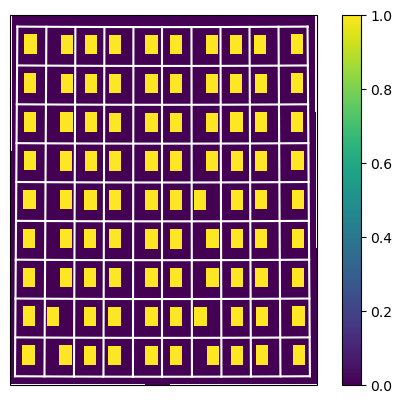

In [5]:
hits = target_mesh.source_hits( topo_lon, topo_lat )

ax = plt.subplot(111, projection=cartopy.crs.NearsidePerspective(central_longitude=1.5, central_latitude=51))
im = topo_mesh.pcolormesh( ax, hits, transform=cartopy.crs.PlateCarree() )
plt.colorbar(im, ax=ax)
target_mesh.plot(ax, linecolor='w', transform=cartopy.crs.Geodetic())

Refine grid by 2 and re-calculate flagged cells

<GMesh nj:18 ni:20 shape:(18,20)>


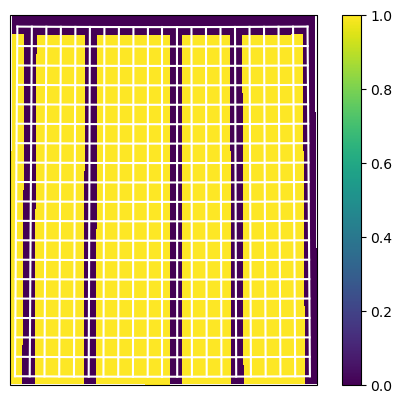

In [6]:
refine_level_1 = target_mesh.refineby2()
print( refine_level_1 )
hits = refine_level_1.source_hits( topo_lon, topo_lat )

ax = plt.subplot(111, projection=cartopy.crs.NearsidePerspective(central_longitude=1.5, central_latitude=51))
im = topo_mesh.pcolormesh( ax, hits, transform=cartopy.crs.PlateCarree() )
plt.colorbar(im, ax=ax)
refine_level_1.plot(ax, linecolor='w', transform=cartopy.crs.Geodetic())

Further refine by 2 and re-calculate flagged cells

<GMesh nj:36 ni:40 shape:(36,40)>


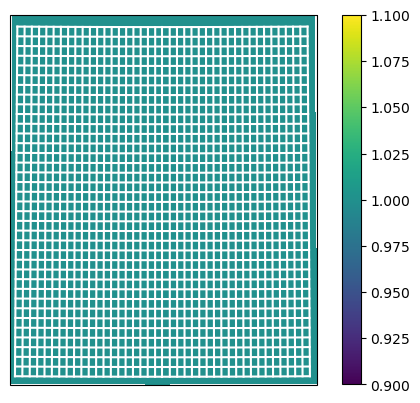

In [7]:
refine_level_2 = refine_level_1.refineby2()
print( refine_level_2 )
hits = refine_level_2.source_hits( topo_lon, topo_lat )

ax = plt.subplot(111, projection=cartopy.crs.NearsidePerspective(central_longitude=1.5, central_latitude=51))
im = topo_mesh.pcolormesh( ax, hits, transform=cartopy.crs.PlateCarree() )
plt.colorbar(im, ax=ax)
refine_level_2.plot(ax, linecolor='w', transform=cartopy.crs.PlateCarree())

In [8]:
target_mesh.refine_loop( topo_lon, topo_lat );

Refine level 0 <GMesh nj:9 ni:10 shape:(9,10)> Hit 90 out of 475 cells (0.0014 Mb)
Refine level 1 <GMesh nj:18 ni:20 shape:(18,20)> Hit 360 out of 475 cells (0.0055 Mb)
Refine level 2 <GMesh nj:36 ni:40 shape:(36,40)> Hit 475 out of 475 cells (0.0220 Mb)


# Test for source grid with converging Meridians and analog of polar cap

In [9]:
# Mesh across North Pole
target_mesh = GMesh.GMesh( lon=np.linspace(-.5, .5, 3), lat=np.linspace(-.5, .5, 3) )
target_mesh.rotate(y_rot=-90)
print( target_mesh.lat.max() )

# Reload topography
topo_lon = np.array( topo_data.variables[vx][:] )
topo_lat = np.array( topo_data.variables[vy][:] )
print('topography grid array shapes: ' , topo_lon.shape,topo_lat.shape)
print('topography longitude range:',topo_lon.min(),topo_lon.max())
print('topography latitude range:',topo_lat.min(),topo_lat.max())
# Indices in topographic data
tis,tjs = target_mesh.find_source_spanning_slices( topo_lon, topo_lat )
# tis,tjs = slice(ti.min(), ti.max()+1,1), slice(tj.min(), tj.max()+1,1)
tis=slice(0,43200,5)
print('Slices:', tis, tjs )
# Read elevation data
topo_elv = topo_data.variables[ve][tjs,tis]
# Extract appropriate coordinates
topo_lon = topo_lon[tis]
topo_lat = topo_lat[tjs]

print('Topo shape:', topo_elv.shape)
print('topography longitude range:',topo_lon.min(),topo_lon.max())
print('topography latitude range:',topo_lat.min(),topo_lat.max())

90.0
topography grid array shapes:  (43200,) (21600,)
topography longitude range: -179.99583333333334 179.99583333333334
topography latitude range: -89.99583333333334 89.99583333333334
Slices: slice(0, 43200, 5) slice(21515, 21600, None)
Topo shape: (85, 8640)
topography longitude range: -179.99583333333334 179.96249999999998
topography latitude range: 89.29583333333332 89.99583333333334


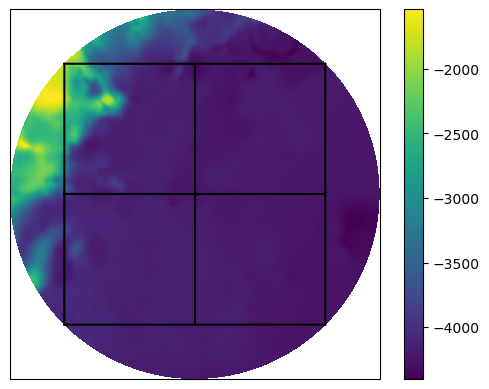

In [10]:
ax = plt.subplot(111, projection=cartopy.crs.NorthPolarStereo())
topomesh = GMesh.GMesh(lon=topo_lon, lat=topo_lat, from_cell_center=True)
im = topomesh.pcolormesh(ax, topo_elv, transform=cartopy.crs.PlateCarree())
plt.colorbar(im,ax=ax)

target_mesh.plot(ax, transform=cartopy.crs.Geodetic())

In [11]:
R = target_mesh.refine_loop( topo_lon, topo_lat )

Refine level 0 <GMesh nj:2 ni:2 shape:(2,2)> Hit 259204 out of 734400 cells (0.0001 Mb)
Refine level 1 <GMesh nj:4 ni:4 shape:(4,4)> Hit 259212 out of 734400 cells (0.0002 Mb)
Refine level 2 <GMesh nj:8 ni:8 shape:(8,8)> Hit 259252 out of 734400 cells (0.0010 Mb)
Refine level 3 <GMesh nj:16 ni:16 shape:(16,16)> Hit 259404 out of 734400 cells (0.0039 Mb)
Refine level 4 <GMesh nj:32 ni:32 shape:(32,32)> Hit 260016 out of 734400 cells (0.0156 Mb)
Refine level 5 <GMesh nj:64 ni:64 shape:(64,64)> Hit 262484 out of 734400 cells (0.0625 Mb)
Refine level 6 <GMesh nj:128 ni:128 shape:(128,128)> Hit 272340 out of 734400 cells (0.2500 Mb)
Refine level 7 <GMesh nj:256 ni:256 shape:(256,256)> Hit 309736 out of 734400 cells (1.0000 Mb)
Refine level 8 <GMesh nj:512 ni:512 shape:(512,512)> Hit 427398 out of 734400 cells (4.0000 Mb)
Refine level 9 <GMesh nj:1024 ni:1024 shape:(1024,1024)> Hit 559750 out of 734400 cells (16.0000 Mb)
Refine level 10 <GMesh nj:2048 ni:2048 shape:(2048,2048)> Hit 583160 ou

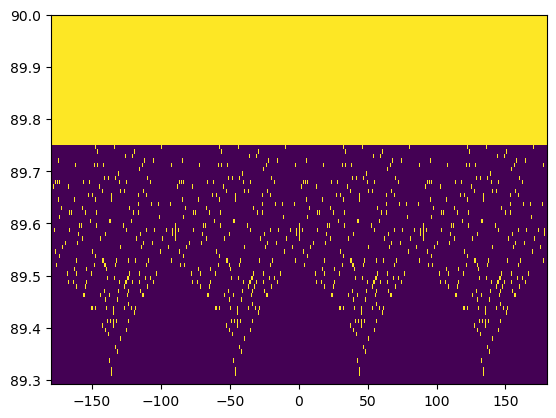

In [12]:
ax = plt.subplot(111)#, projection=cartopy.crs.NorthPolarStereo())
hits = R[6].source_hits( topo_lon, topo_lat )
topomesh.pcolormesh(ax, hits)#, transform=cartopy.crs.PlateCarree());